In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('KA.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Recovered'

In [5]:
df.Date.describe()

count           115
unique          115
top       20-Apr-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Deceased
0,14-Mar-20,6,0,1
1,15-Mar-20,0,0,0
2,16-Mar-20,1,0,0
3,17-Mar-20,2,0,0
4,18-Mar-20,5,0,0
...,...,...,...,...
110,02-Jul-20,1502,271,19
111,03-Jul-20,1694,471,21
112,04-Jul-20,1839,439,42
113,05-Jul-20,1925,603,37


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Deceased
0,2020-03-14,6,0,1
1,2020-03-15,0,0,0
2,2020-03-16,1,0,0
3,2020-03-17,2,0,0
4,2020-03-18,5,0,0


In [9]:
df

,Date,Confirmed,Recovered,Deceased
0,2020-03-14,6,0,1
1,2020-03-15,0,0,0
2,2020-03-16,1,0,0
3,2020-03-17,2,0,0
4,2020-03-18,5,0,0
...,...,...,...,...
110,2020-07-02,1502,271,19
111,2020-07-03,1694,471,21
112,2020-07-04,1839,439,42
113,2020-07-05,1925,603,37


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Deceased
Date,,,
2020-03-14,6,0,1
2020-03-15,0,0,0
2020-03-16,1,0,0
2020-03-17,2,0,0
2020-03-18,5,0,0
...,...,...,...
2020-07-02,1502,271,19
2020-07-03,1694,471,21
2020-07-04,1839,439,42


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Deceased
Date,,,
2020-03-14,6,0,1
2020-03-15,0,0,0
2020-03-16,1,0,0
2020-03-17,2,0,0
2020-03-18,5,0,0
...,...,...,...
2020-07-02,1502,271,19
2020-07-03,1694,471,21
2020-07-04,1839,439,42


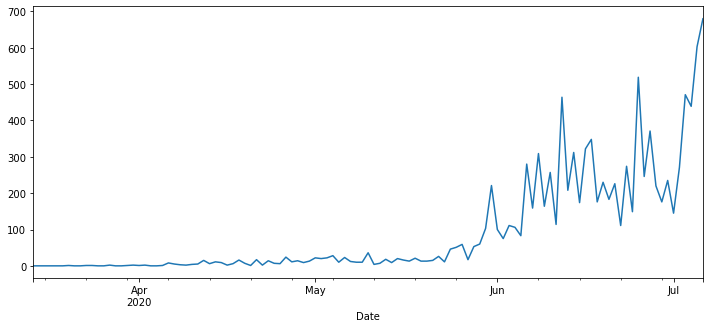

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic        1.056565
p-value                   0.994828
# lags used              13.000000
# observations          101.000000
critical value (1%)      -3.496818
critical value (5%)      -2.890611
critical value (10%)     -2.582277
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


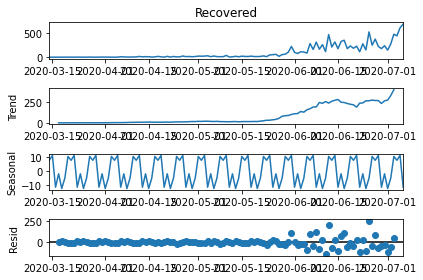

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.830363
p-value                  0.002611
# lags used             13.000000
# observations          99.000000
critical value (1%)     -3.498198
critical value (5%)     -2.891208
critical value (10%)    -2.582596
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=13)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1344.026, BIC=1349.499, Time=0.011 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1282.225, BIC=1290.434, Time=0.035 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1302.942, BIC=1311.151, Time=0.077 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1342.569, BIC=1345.305, Time=0.011 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1282.929, BIC=1293.874, Time=0.081 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1283.047, BIC=1293.992, Time=0.095 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1284.914, BIC=1298.595, Time=0.170 seconds
Total fit time: 0.484 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -638.113
Date:                Thu, 16 Jul 2020   AIC                           1282.225
Time:                        00:53:35   BIC                           1290.434
Sample:                             0   HQIC                          1285.557
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.5063      8.177      1.163      0.245      -6.521      25.533
ar.L1         -0.6531      0.049    -13.444      0.000      -0.748      -0.558
sigma2      4239.3323    360.396     11.763      0.000    3532.969    4945.696
===================================================================================
Ljung-Box (Q):                       38.60   Jarque-Bera (JB):               286.57
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):             124.64   Skew:                             1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:104]
test = df.iloc[104:111]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(1, 1, 0))
model = SARIMAX(train[para],order=(1, 1, 0),seasonal_order=(1,1,0,13))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Recovered   No. Observations:                  104
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 13)   Log Likelihood                -485.011
Date:                            Thu, 16 Jul 2020   AIC                            976.022
Time:                                    00:53:35   BIC                            983.521
Sample:                                03-14-2020   HQIC                           979.046
                                     - 06-25-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7104      0.045    -15.828      0.000      -0.798      -0.622
ar.S.L13      -0.3108      0.068     -4.586      0.000      -0.444      -0.178
sigma2      2746.0728    208.193     13.190      0.000    2338.022    3154.124
===================================================================================
Ljung-Box (Q):                       29.32   Jarque-Bera (JB):               139.39
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):             172.55   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
# start=len(train)
# end=len(train)+len(test)-1

start=104
end=110

# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1,1,0,13) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

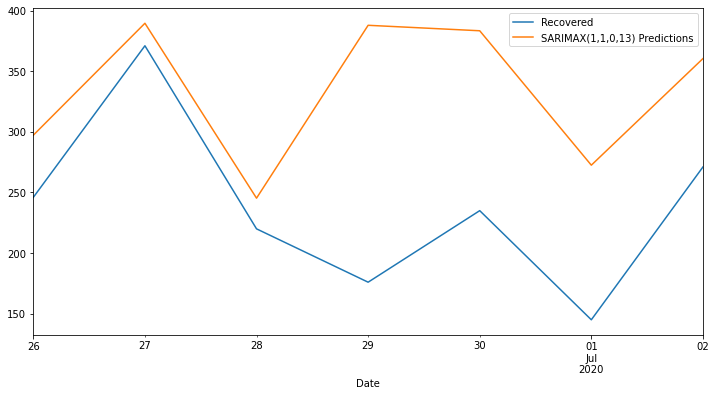

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

96.04167192857751

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

48.82799431257796 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Deceased,d1,forecast
Date,,,,,
2020-03-14,6,0,1,NaN,NaN
2020-03-15,0,0,0,NaN,NaN
2020-03-16,1,0,0,0.0,NaN
2020-03-17,2,0,0,0.0,NaN
2020-03-18,5,0,0,0.0,NaN
...,...,...,...,...,...
2020-07-02,1502,271,19,216.0,360.411548
2020-07-03,1694,471,21,74.0,NaN
2020-07-04,1839,439,42,-232.0,NaN


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Recovered': Date
 2020-06-26    246
 2020-06-27    371
 2020-06-28    220
 2020-06-29    176
 2020-06-30    235
 2020-07-01    145
 2020-07-02    271
 Freq: D, Name: Recovered, dtype: int64,
 'Predicted_Recovered': 2020-06-26    297.240164
 2020-06-27    389.560596
 2020-06-28    245.301940
 2020-06-29    387.889663
 2020-06-30    383.376184
 2020-07-01    272.511609
 2020-07-02    360.411548
 Freq: D, Name: SARIMAX(1,1,0,13) Predictions, dtype: float64}

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Recovered,Predicted_Recovered
Date,,
2020-06-26,246,297.240164
2020-06-27,371,389.560596
2020-06-28,220,245.301940
2020-06-29,176,387.889663
2020-06-30,235,383.376184
2020-07-01,145,272.511609
2020-07-02,271,360.411548


In [33]:
# predicted_df.to_csv('Predicted_KA.csv')
predicted_csv = pd.read_csv('Predicted_KA.csv')

predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
predicted_csv.set_index('Date', inplace=True)
predicted_csv.index.freq = 'D'
# print(predicted_csv)
# predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(predicted_csv)
predicted_csv.to_csv('Predicted_KA.csv')

            Confirmed  Predicted_Confirmed  Recovered  Predicted_Recovered
Date                                                                      
2020-06-26        445           441.549726        246           297.240164
2020-06-27        918           577.577300        371           389.560596
2020-06-28       1267           676.786800        220           245.301940
2020-06-29       1105           569.298222        176           387.889663
2020-06-30        947           644.772921        235           383.376184
2020-07-01       1272           739.714345        145           272.511609
2020-07-02       1502           686.556282        271           360.411548


In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Deceased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Deceased,forecast
2020-03-14,6,0,1,NaN
2020-03-15,0,0,0,NaN
2020-03-16,1,0,0,NaN
2020-03-17,2,0,0,NaN
2020-03-18,5,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Recovered,forecast
2020-03-14,0,NaN
2020-03-15,0,NaN
2020-03-16,0,NaN
2020-03-17,0,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

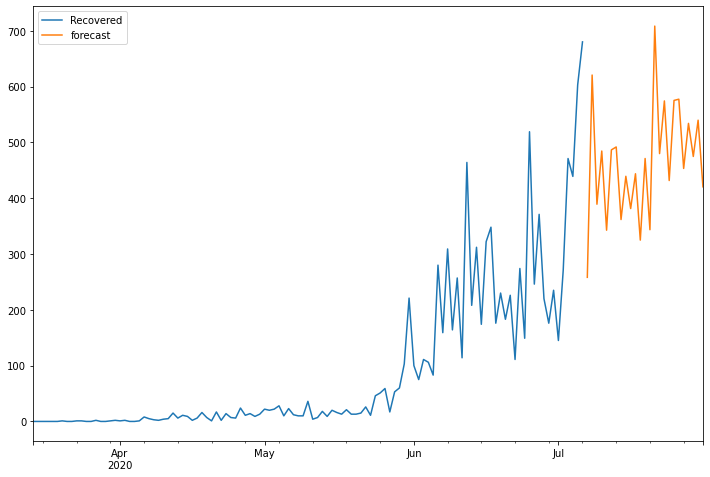

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Recovered': 2020-07-07    258.166239
 2020-07-08    620.596712
 2020-07-09    389.158892
 2020-07-10    484.425208
 2020-07-11    342.597054
 2020-07-12    486.521676
 2020-07-13    491.735405
 2020-07-14    361.698754
 2020-07-15    439.187890
 2020-07-16    381.410003
 2020-07-17    443.724791
 2020-07-18    324.858843
 2020-07-19    471.047515
 2020-07-20    343.483945
 2020-07-21    708.282564
 2020-07-22    479.840906
 2020-07-23    574.199805
 2020-07-24    431.610667
 2020-07-25    575.123894
 2020-07-26    577.311994
 2020-07-27    453.235153
 2020-07-28    533.958019
 2020-07-29    474.710742
 2020-07-30    539.702752
 2020-07-31    420.315679
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Recovered
2020-07-07,258.166239
2020-07-08,620.596712
2020-07-09,389.158892
2020-07-10,484.425208
2020-07-11,342.597054
2020-07-12,486.521676
2020-07-13,491.735405
2020-07-14,361.698754
2020-07-15,439.187890
2020-07-16,381.410003


In [44]:
# future_predicted_df.index.names = ['Date']
# future_predicted_df.index.freq = 'D'
# future_predicted_df.to_csv('Future_Predicted_KA.csv')

future_predicted_csv = pd.read_csv('Future_Predicted_KA.csv')

future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
future_predicted_csv.set_index('Date', inplace=True)
future_predicted_csv.index.freq = 'D'
# print(future_predicted_csv)
# future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(future_predicted_csv)
future_predicted_csv.to_csv('Future_Predicted_KA.csv')

            Future_Predicted_Confirmed  Future_Predicted_Recovered
Date                                                              
2020-07-07                  777.893070                  258.166239
2020-07-08                  858.027548                  620.596712
2020-07-09                  914.820825                  389.158892
2020-07-10                  959.682850                  484.425208
2020-07-11                  991.502909                  342.597054
2020-07-12                 1137.802459                  486.521676
2020-07-13                 1260.445546                  491.735405
2020-07-14                 1150.246867                  361.698754
2020-07-15                 1251.140302                  439.187890
2020-07-16                 1352.613544                  381.410003
2020-07-17                 1329.105982                  443.724791
2020-07-18                 1339.255819                  324.858843
2020-07-19                 1468.966551                  471.04